In [1]:
ON_COLAB = False

In [2]:
if ON_COLAB:
    # ----- for colab
    from zipfile import ZipFile

    with ZipFile("dataset/images.zip", 'r') as zObject:

        zObject.extractall(
            path="dataset")

In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root = Path("/home/liam/Desktop/magistrale/computervision/progetto/modulo_due/ipcv-assignment-2/dataset")
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [5]:
import random
from torchvision import transforms
from torchvision.transforms import functional as tF

class Random90DegreeRotation:
    """Custom transform for 90-degree rotations with specific probabilities."""
    def __call__(self, img):
        prob = random.random()
        if prob < 0.5:
            return img  # No rotation
        elif prob < 0.75:
            return tF.rotate(img, angle=-90)  # Rotate 90 degrees left
        else:
            return tF.rotate(img, angle=90)  # Rotate 90 degrees right

class OuterRandomCrop:
    """Custom transform to randomly crop the same amount of pixels from each side of the image."""
    def __init__(self, max_pixels_to_crop):
        """
        Args:
            max_pixels_to_crop (int): The maximum number of pixels to subtract from each side of the image.
        """
        self.max_pixels_to_crop = max_pixels_to_crop

    def __call__(self, img):
        # decides whether to apply the crop (75% chance)
        if random.random() < 0.25:
            return img

        # randomly select the number of pixels to crop (between 0 and max_pixels_to_crop)
        pixels_to_crop = random.randint(0, self.max_pixels_to_crop)

        width, height = img.size
        crop_left = pixels_to_crop
        crop_top = pixels_to_crop
        crop_width = width - 2 * pixels_to_crop
        crop_height = height - 2 * pixels_to_crop

        if crop_width <= 0 or crop_height <= 0:
            raise ValueError("The number of pixels to crop is too large for the image dimensions.")

        return tF.crop(img, top=crop_top, left=crop_left, height=crop_height, width=crop_width)


convert_compatible = transforms.Compose([
    transforms.Resize((224, 224)),     # Deterministic resize
    transforms.ToTensor(),             # Format conversion only
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # image net normalization values
])

transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),       # Random horizontal flip
    OuterRandomCrop(20),                 # Custom outer crop
    Random90DegreeRotation(),                    # Custom 90-degree rotation
    transforms.RandomRotation(10),              # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.4),      # Adjust brightness slightly
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4896734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


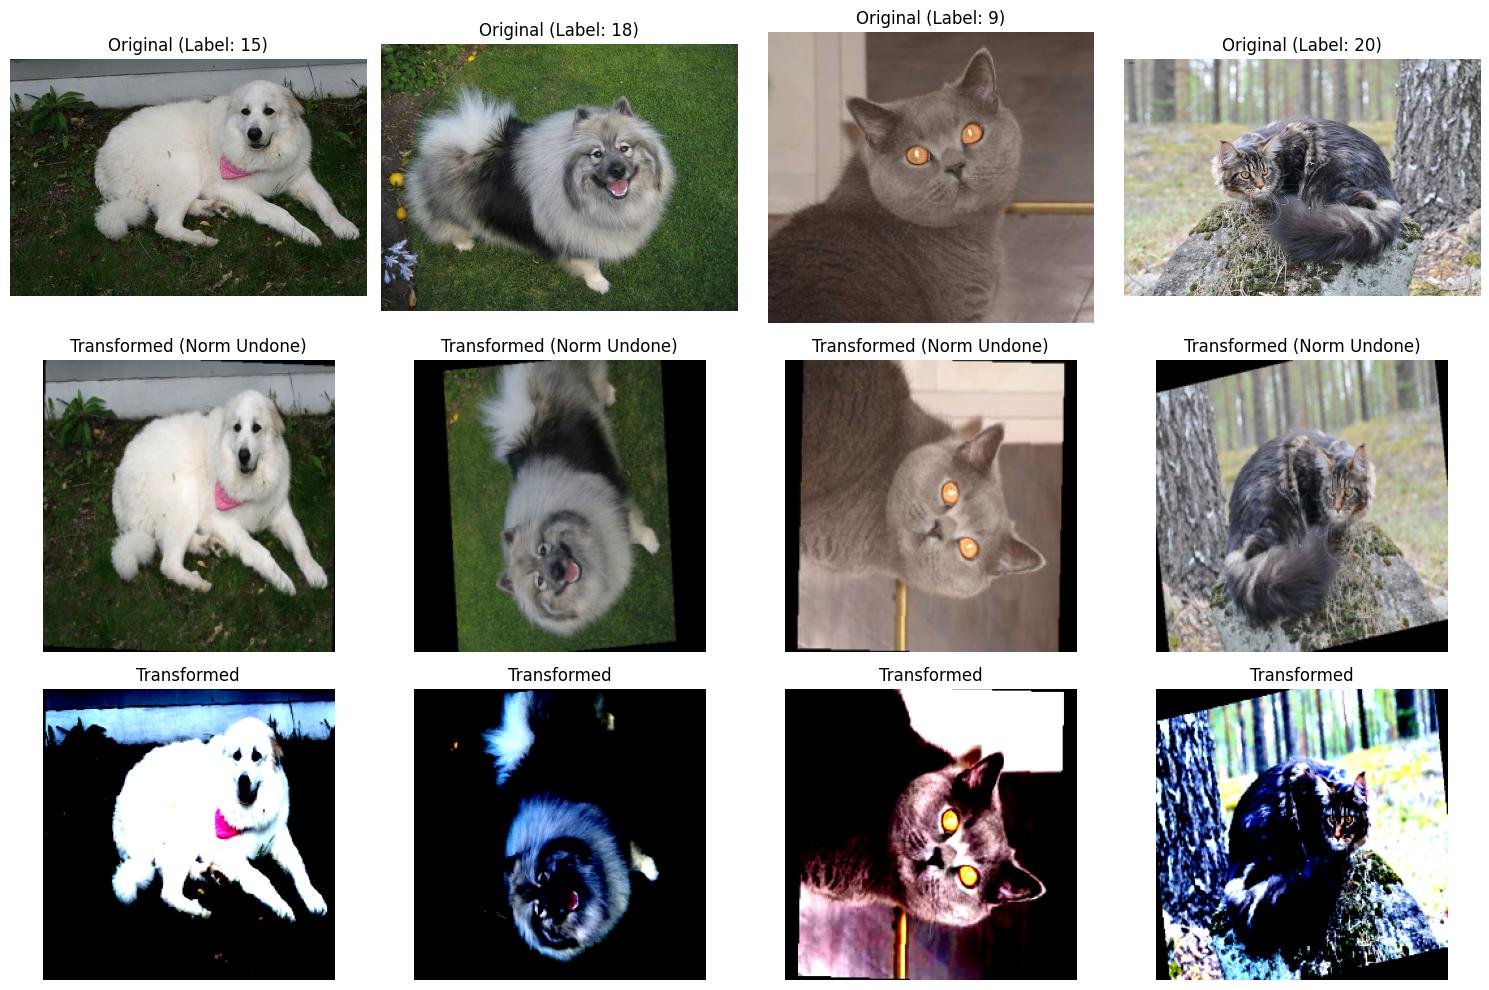

In [7]:
import matplotlib.pyplot as plt
import random

# Function to display images
def display_image_comparison(dataset, num_images=4):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))  # 3 rows, num_images columns

    for i in range(num_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)

        # Access the raw image without applying the dataset's transform
        img_path = dataset.root / "images" / f"{dataset.names[idx]}.jpg"
        original_img = Image.open(img_path).convert("RGB")  # Load as PIL image
        label = dataset.labels[idx]

        # Apply your transformation
        transformed_with_norm = transform_data_augmentation(original_img)  # Fully transformed with normalization

        # Undo normalization for visualization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transformed_with_norm_np = transformed_with_norm.permute(1, 2, 0).numpy()
        transformed_no_norm_np = std * transformed_with_norm_np + mean  # Undo normalization
        transformed_no_norm_np = transformed_no_norm_np.clip(0, 1)

        # Display original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")

        # Display transformed image with normalization undone
        axes[1, i].imshow(transformed_no_norm_np)
        axes[1, i].set_title("Transformed (Norm Undone)")
        axes[1, i].axis("off")

        # Display fully transformed image (with normalization)
        axes[2, i].imshow(transformed_with_norm_np)
        axes[2, i].set_title("Transformed")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
display_image_comparison(train_dataset, num_images=4)

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, show_all_minibatches_loss=False):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)

            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss or batch_idx in [40, 80]:
                print(f"Batch {batch_idx}/{tot_batches}: loss = {loss.item():.4f}")

            # compute gradients
            loss.backward()

            # update weights
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():  # Don't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        val_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_accuracies


# resnet model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, num_classes=37):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet18(num_classes=37):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


num_classes = 37
model_resnet = resnet18(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet = model_resnet.to(device)


from torchsummary import summary
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

In [11]:
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

train_losses, val_accuracies = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, num_epochs=60, show_all_minibatches_loss=False
)

Batch 40/115: loss = 3.6294
Batch 80/115: loss = 3.6008
Epoch [1/60], Loss: 3.6942, Val Acc: 5.94%
Batch 40/115: loss = 3.4154
Batch 80/115: loss = 3.7108
Epoch [2/60], Loss: 3.5337, Val Acc: 5.94%
Batch 40/115: loss = 3.2408
Batch 80/115: loss = 3.5879
Epoch [3/60], Loss: 3.4311, Val Acc: 6.32%
Batch 40/115: loss = 3.3710
Batch 80/115: loss = 3.3870
Epoch [4/60], Loss: 3.3362, Val Acc: 9.16%
Batch 40/115: loss = 3.2791
Batch 80/115: loss = 2.7057
Epoch [5/60], Loss: 3.2020, Val Acc: 8.40%
Batch 40/115: loss = 3.1600
Batch 80/115: loss = 3.3348
Epoch [6/60], Loss: 3.1271, Val Acc: 12.10%
Batch 40/115: loss = 2.8755
Batch 80/115: loss = 2.6875
Epoch [7/60], Loss: 3.0878, Val Acc: 12.32%
Batch 40/115: loss = 3.0871
Batch 80/115: loss = 2.9078
Epoch [8/60], Loss: 3.0203, Val Acc: 14.94%
Batch 40/115: loss = 3.0631
Batch 80/115: loss = 2.8121
Epoch [9/60], Loss: 2.9492, Val Acc: 15.32%
Batch 40/115: loss = 2.8660
Batch 80/115: loss = 2.9491
Epoch [10/60], Loss: 2.8705, Val Acc: 15.92%
Batc

In [12]:
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)

train_losses_2, val_accuracies_2 = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, num_epochs=5, show_all_minibatches_loss=False
)

Batch 40/115: loss = 0.1795
Batch 80/115: loss = 0.3847
Epoch [1/5], Loss: 0.3677, Val Acc: 47.27%
Batch 40/115: loss = 0.2564
Batch 80/115: loss = 0.2346
Epoch [2/5], Loss: 0.2912, Val Acc: 48.75%
Batch 40/115: loss = 0.2046
Batch 80/115: loss = 0.3263
Epoch [3/5], Loss: 0.2819, Val Acc: 49.02%
Batch 40/115: loss = 0.2076
Batch 80/115: loss = 0.2587
Epoch [4/5], Loss: 0.2683, Val Acc: 48.47%
Batch 40/115: loss = 0.3109
Batch 80/115: loss = 0.2815
Epoch [5/5], Loss: 0.2381, Val Acc: 48.85%


In [14]:
torch.save(model_resnet.state_dict(), "res_net_finale")

In [19]:
# Load the saved model weights and map them to the CPU
model_resnet.load_state_dict(torch.load("res_net_finale", map_location=torch.device('cpu')))
model_resnet = model_resnet.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Set the model to evaluation mode
model_resnet.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass: get predictions
        outputs = model_resnet(batch_images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate and print the accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 53.68%


# Ablation study

# ResNet with no skip connections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock_no_skip(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock_no_skip, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # # # out += identity
        out = F.relu(out)
        return out


class ResNet_no_skip(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, num_classes=37):
        super(ResNet_no_skip, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet18_no_skip(num_classes=37):
    return ResNet_no_skip(BasicBlock_no_skip, [2, 2, 2, 2], num_classes=num_classes)



# ResNet with half the layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        return out


class ResNet_only_two_layers(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, num_classes=37):
        super(ResNet_only_two_layers, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 256, layers[1], stride=2)
        # # # self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # # #self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes) # # # instead of 512

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # # # x = self.layer3(x)
        # # # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet18_only_two_layers(num_classes=37):
    return ResNet_only_two_layers(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# ResNet with layers 4 layers but each layer only has one basic block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        return out


class ResNet_1_basic_block_per_layer(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, num_classes=37):
        super(ResNet_1_basic_block_per_layer, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet18_1_basic_block_per_layer(num_classes=37):
    return ResNet_1_basic_block_per_layer(BasicBlock, [1, 1, 1, 1], num_classes=num_classes) # # # instead of [2,2,2,2]



### Initilize the models

In [ ]:
num_classes = 37
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_resnet_no_skip = resnet18_no_skip(num_classes=num_classes)
model_resnet_no_skip = model_resnet_no_skip.to(device)

model_resnet_only_two_layers = resnet18_only_two_layers(num_classes=num_classes)
model_resnet_only_two_layers = model_resnet_only_two_layers.to(device)

model_resnet_1_basic_block_per_layer = resnet18_1_basic_block_per_layer(num_classes=num_classes)
model_resnet_1_basic_block_per_layer = model_resnet_1_basic_block_per_layer.to(device)

In [ ]:

# text summary
from torchsummary import summary

print((("-"*50)+"\n")*3)
print("ResNet with no skip connections summary")
print((("-"*50)+"\n")*3)
summary(model_resnet_no_skip, input_size=(3, 224, 224))

print((("-"*50)+"\n")*3)
print("ResNet with only two layers summary")
print((("-"*50)+"\n")*3)
summary(model_resnet_only_two_layers, input_size=(3, 224, 224))

print((("-"*50)+"\n")*3)
print("ResNet with only one basic block per layer connections summary")
print((("-"*50)+"\n")*3)
summary(model_resnet_1_basic_block_per_layer, input_size=(3, 224, 224))

dir = "./architecture_visualizations/"

architecture = "model_resnet_no_skip"
# generate_architecture_image(model_resnet_no_skip, dir + architecture)

architecture = "model_resnet_only_two_layers"
# generate_architecture_image(model_resnet_only_two_layers, dir + architecture)

architecture = "model_resnet_1_basic_block_per_layer"
# generate_architecture_image(model_resnet_1_basic_block_per_layer, dir + architecture)


# Architecture visualizations

In [ ]:
from torchviz import make_dot
from torchsummary import summary
from IPython.display import Image as IpImage

# given model and a file path, saves the image of the architecture of the model
# if successful returns the file path, otherwise returns None
def generate_architecture_image(model, filepath):
    try :
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        output = model(dummy_input) # pass the dummy input through the model

        make_dot(
            output, params=dict(model.named_parameters())) \
            .render(filepath, format="png"
        )
    except:
        return None

    return filepath

## ResNet with no skip connections

In [ ]:
IpImage(filename = dir + "model_resnet_no_skip" + ".png")

## ResNet with 2 layers

In [ ]:
IpImage(filename = dir + "model_resnet_only_two_layers" + ".png")

## ResNet with basic block reduced

In [ ]:
IpImage(filename = dir + "model_resnet_1_basic_block_per_layer" + ".png")

# Degraded models training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_no_skip = optim.Adam(model_resnet_no_skip.parameters(), lr=0.001)
optimizer_only_two_layers = optim.Adam(model_resnet_only_two_layers.parameters(), lr=0.01)
optimizer_1_basic_block_per_layer = optim.Adam(model_resnet_1_basic_block_per_layer.parameters(), lr=0.001)

In [ ]:
ON_COLAB = False

In [ ]:
if ON_COLAB:
    # ----- for colab
    from zipfile import ZipFile

    with ZipFile("dataset/images.zip", 'r') as zObject:

        zObject.extractall(
            path="dataset")

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

# ablation study training function REDEFINITION: modified to show class accuracies TODO retrain default model with this function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, show_all_minibatches_loss=False):
    train_losses = []
    val_accuracies = []
    val_class_accuracies = []

    # Get number of classes from the model's output layer
    num_classes = model.fc.out_features

    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)

            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss or batch_idx in [40, 80]:
                print(f"Batch {batch_idx}/{tot_batches}: loss = {loss.item():.4f}")

            # compute gradients
            loss.backward()

            # update weights
            optimizer.step()

            running_loss += loss.item()

        # validation phase
        model.eval()
        correct = 0
        total = 0

        # initialize per-class counters
        class_correct = torch.zeros(num_classes, dtype=torch.long)
        class_total = torch.zeros(num_classes, dtype=torch.long)

        with torch.no_grad():  # doesn't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

                # calculate per-class accuracy
                for i in range(batch_labels.size(0)):
                    label = batch_labels[i]
                    class_total[label] += 1
                    if predicted[i] == label:
                        class_correct[label] += 1

        val_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # calculate per-class accuracies for this epoch
        epoch_class_accuracies = []
        for i in range(num_classes):
            if class_total[i] > 0:
                class_acc = class_correct[i].item() / class_total[i].item()
            else:
                class_acc = 0.0  # no samples for this class in validation set
            epoch_class_accuracies.append(class_acc)

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(epoch_class_accuracies)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_accuracies, val_class_accuracies

### ResNet with no skip connections training

In [ ]:
train_losses_no_skip, val_accuracies_no_skip, val_class_accuracies_no_skip = train_model(
    model_resnet_no_skip, train_loader, val_loader, criterion, optimizer_no_skip, num_epochs=60, show_all_minibatches_loss=False
)